In [1]:
import pandas as pd

In [2]:
# Load the manually created Shipin data
shipin = pd.read_csv('../Data/Table of Shipin.csv')
shipin

,Dynasty,Author,Rank,Origin,Remarks on Literature
0,NaN,《古诗》,Upper,《国风》,NaN
1,Han,李陵,Upper,《楚辞》,文多凄怆，怨者之流。
2,Han,班姬,Upper,李陵,《团扇》短章，辞旨清捷，怨深文绮，得匹妇之致。侏儒一节，可以知其工矣。
3,Wei,曹植,Upper,《国风》,骨气奇高，词彩华茂，情兼雅怨，体被文质，粲溢今古，卓尔不群。嗟乎！陈思之于文章也，譬人伦之有...
4,Wei,刘桢,Upper,《古诗》,仗气爱奇，动多振绝。贞骨凌霜，高风跨俗。但气过其文，雕润恨少。然自陈思已下，桢称独步。
...,...,...,...,...,...
118,Qi,陆厥,Lower,NaN,自制未优，非言之失也。
119,Liang,虞羲,Lower,NaN,子阳诗奇句清拔，谢朓常嗟颂之。
120,Liang,江洪,Lower,NaN,洪虽无多，亦能自迥出。
121,Liang,鲍行卿,Lower,NaN,行卿少年，甚擅风谣之美。


In [3]:
# Convert author name to pinyin
from pypinyin import lazy_pinyin
def chinese_name_to_pinyin(name):
    surname = name[0]
    given = name[1:]
    py_surname = lazy_pinyin(surname)[0].capitalize()
    py_given   = ''.join(lazy_pinyin(given)).capitalize()
    return f"{py_surname} {py_given}"
shipin['Author Pinyin'] = shipin['Author'].apply(chinese_name_to_pinyin)
shipin['Author Pinyin'] = shipin['Author Pinyin'].replace({'《 Gushi》': 'Gushi', # manually correct format
                                                           'Mou Xi': 'Miao Xi'}) # manually correct problematic conversion
shipin

,Dynasty,Author,Rank,Origin,Remarks on Literature,Author Pinyin
0,NaN,《古诗》,Upper,《国风》,NaN,Gushi
1,Han,李陵,Upper,《楚辞》,文多凄怆，怨者之流。,Li Ling
2,Han,班姬,Upper,李陵,《团扇》短章，辞旨清捷，怨深文绮，得匹妇之致。侏儒一节，可以知其工矣。,Ban Ji
3,Wei,曹植,Upper,《国风》,骨气奇高，词彩华茂，情兼雅怨，体被文质，粲溢今古，卓尔不群。嗟乎！陈思之于文章也，譬人伦之有...,Cao Zhi
4,Wei,刘桢,Upper,《古诗》,仗气爱奇，动多振绝。贞骨凌霜，高风跨俗。但气过其文，雕润恨少。然自陈思已下，桢称独步。,Liu Zhen
...,...,...,...,...,...,...
118,Qi,陆厥,Lower,NaN,自制未优，非言之失也。,Lu Jue
119,Liang,虞羲,Lower,NaN,子阳诗奇句清拔，谢朓常嗟颂之。,Yu Xi
120,Liang,江洪,Lower,NaN,洪虽无多，亦能自迥出。,Jiang Hong
121,Liang,鲍行卿,Lower,NaN,行卿少年，甚擅风谣之美。,Bao Xingqing


# Embedding Generation

In [4]:
import torch
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    summed = torch.sum(token_embeddings * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

In [5]:
def embed_texts(texts, tokenizer, model):
    all_embs = []
    for text in texts:
        inputs = tokenizer(text,
                           padding=True,
                           truncation=True,
                           max_length=512,
                           return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = mean_pooling(outputs, inputs.attention_mask)
        all_embs.append(pooled)
    return torch.cat(all_embs).cpu().numpy()

In [6]:
# Use the fine-tuned Guwenbert model
import numpy as np
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("../Models/fine-tuned-best_lr1e-05_bs32")
model = AutoModel.from_pretrained("../Models/fine-tuned-best_lr1e-05_bs32")

Some weights of RobertaModel were not initialized from the model checkpoint at ../Models/fine-tuned-best_lr1e-05_bs32 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Generate embeddings for evaluative remarks
mask = shipin['Remarks on Literature'].notna()
idxs = shipin.index[mask]
texts = shipin.loc[idxs, 'Remarks on Literature'].tolist()
embs = embed_texts(texts, tokenizer, model)
emb_series = pd.Series(list(embs), index=idxs)
shipin['Embedding'] = None
shipin.loc[emb_series.index, 'Embedding'] = emb_series
shipin['Embedding'] = shipin['Embedding'].apply(lambda x: np.nan if x is None else x)
shipin

,Dynasty,Author,Rank,Origin,Remarks on Literature,Author Pinyin,Embedding
0,NaN,《古诗》,Upper,《国风》,NaN,Gushi,NaN
1,Han,李陵,Upper,《楚辞》,文多凄怆，怨者之流。,Li Ling,"[-0.008882296, -0.058540527, 0.13038914, 0.115..."
2,Han,班姬,Upper,李陵,《团扇》短章，辞旨清捷，怨深文绮，得匹妇之致。侏儒一节，可以知其工矣。,Ban Ji,"[0.015972693, -0.12345523, -0.0021621867, 0.01..."
3,Wei,曹植,Upper,《国风》,骨气奇高，词彩华茂，情兼雅怨，体被文质，粲溢今古，卓尔不群。嗟乎！陈思之于文章也，譬人伦之有...,Cao Zhi,"[0.12235799, -0.17545713, 0.06092672, -0.08392..."
4,Wei,刘桢,Upper,《古诗》,仗气爱奇，动多振绝。贞骨凌霜，高风跨俗。但气过其文，雕润恨少。然自陈思已下，桢称独步。,Liu Zhen,"[0.14376694, -0.15150079, 0.023103958, -0.0512..."
...,...,...,...,...,...,...,...
118,Qi,陆厥,Lower,NaN,自制未优，非言之失也。,Lu Jue,"[0.13412152, -0.09696247, 0.0038412577, -0.006..."
119,Liang,虞羲,Lower,NaN,子阳诗奇句清拔，谢朓常嗟颂之。,Yu Xi,"[-0.0629491, -0.083658785, 0.089192085, 0.0359..."
120,Liang,江洪,Lower,NaN,洪虽无多，亦能自迥出。,Jiang Hong,"[-0.08096432, -0.0066346256, 0.2764529, 0.0343..."
121,Liang,鲍行卿,Lower,NaN,行卿少年，甚擅风谣之美。,Bao Xingqing,"[-0.20044394, -0.080379896, -0.031366456, 0.10..."


In [8]:
# Load the poetry collection
import json
with open('../Data/Xianqin Han Wei Jin Nanbeichao shi/test_set.json', 'r', encoding='utf-8') as f:
    shipin_poet_poems = json.load(f)

records = []
for author, poems in shipin_poet_poems.items():
    for poem in poems:
        records.append({
            'Author': author,
            'Title': poem.get('title'),
            'Text': poem.get('poem')
        })
poems_df = pd.DataFrame(records)
poems_df

,Author,Title,Text
0,李陵,歌,径万里兮度沙漠。为君将兮奋匈奴。路穷绝兮矢刃摧。士众灭兮名已隤。老母已死虽欲报恩将安归。
1,班婕妤,怨诗,新裂齐纨素。鲜洁如霜雪。裁为合欢扇。团团似明月。出入君怀袖。动摇微风发。常恐秋节至。凉飚夺炎...
2,班固,明堂诗,於昭明堂。明堂孔阳。圣皇宗祀。穆穆煌煌。上帝宴飨。五位时序。谁其配之。世祖光武。普天率土。各...
3,班固,辟雍诗,乃流辟雍。辟雍汤汤。圣皇莅止。造舟为梁。皤皤国老。乃父乃兄。抑抑威仪。孝友光明。於赫太上。示...
4,班固,灵台诗,乃经灵台。灵台既崇。帝勤时登。爰考休徵。三光宣精。五行布序。习习祥风。祁祁甘雨。百谷蓁蓁。庶...
...,...,...,...
1814,江洪,为傅建康咏红笺诗,杂彩何足奇。惟红偏作可。灼烁类蕖开。轻明似霞破。镂质卷芳脂。裁花承百和。且传别离心。复是相思...
1815,江洪,咏蔷薇诗,当户种蔷薇。枝叶太葳蕤。不摇香已乱。无风花自飞。春闺不能静。开匣对明妃。曲池浮采采。斜岸列依...
1816,江洪,江行诗,日没风光静。远山清无云。潮落晚洲出。浪罢沙成文。挟琴上高岸。望月弹明君。去家未千里。断绝怨离群。
1817,江洪,咏荷诗,泽陂有微草。能花复能实。碧叶喜翻风。红英宜照日。移居玉池上。托根庶非失。如何霜露交。应与飞蓬匹。


In [9]:
# Manually unify author names
unique_authors = poems_df['Author'].unique().tolist()
shipin_author = shipin['Author'].tolist()
for author in unique_authors:
    if author not in shipin_author:
        print(author)
# Other inconsistencies, such as 陶潜 recorded as 陶渊明 in 先秦汉魏晋南北朝诗, are already manually corrected in data collection
author_replacements = {
    "班婕妤": "班姬",
    "魏武帝曹操": "曹操",
    "魏明帝曹叡": "曹叡",
    "魏文帝曹丕": "曹丕",
    "陈思王曹植": "曹植",
    "楚王曹彪": "曹彪",
    "帛道猷": "道猷",
    "南平王刘铄": "刘铄",
    "宋孝武帝刘骏": "刘骏",
    "汤惠休": "惠休",
    "齐高帝萧道成": "萧道成",
}
poems_df['Author'] = poems_df['Author'].replace(author_replacements)
poems_df['Author Pinyin'] = poems_df['Author'].apply(chinese_name_to_pinyin)
poems_df

班婕妤
魏武帝曹操
魏明帝曹叡
魏文帝曹丕
陈思王曹植
楚王曹彪
帛道猷
南平王刘铄
宋孝武帝刘骏
汤惠休
齐高帝萧道成


,Author,Title,Text,Author Pinyin
0,李陵,歌,径万里兮度沙漠。为君将兮奋匈奴。路穷绝兮矢刃摧。士众灭兮名已隤。老母已死虽欲报恩将安归。,Li Ling
1,班姬,怨诗,新裂齐纨素。鲜洁如霜雪。裁为合欢扇。团团似明月。出入君怀袖。动摇微风发。常恐秋节至。凉飚夺炎...,Ban Ji
2,班固,明堂诗,於昭明堂。明堂孔阳。圣皇宗祀。穆穆煌煌。上帝宴飨。五位时序。谁其配之。世祖光武。普天率土。各...,Ban Gu
3,班固,辟雍诗,乃流辟雍。辟雍汤汤。圣皇莅止。造舟为梁。皤皤国老。乃父乃兄。抑抑威仪。孝友光明。於赫太上。示...,Ban Gu
4,班固,灵台诗,乃经灵台。灵台既崇。帝勤时登。爰考休徵。三光宣精。五行布序。习习祥风。祁祁甘雨。百谷蓁蓁。庶...,Ban Gu
...,...,...,...,...
1814,江洪,为傅建康咏红笺诗,杂彩何足奇。惟红偏作可。灼烁类蕖开。轻明似霞破。镂质卷芳脂。裁花承百和。且传别离心。复是相思...,Jiang Hong
1815,江洪,咏蔷薇诗,当户种蔷薇。枝叶太葳蕤。不摇香已乱。无风花自飞。春闺不能静。开匣对明妃。曲池浮采采。斜岸列依...,Jiang Hong
1816,江洪,江行诗,日没风光静。远山清无云。潮落晚洲出。浪罢沙成文。挟琴上高岸。望月弹明君。去家未千里。断绝怨离群。,Jiang Hong
1817,江洪,咏荷诗,泽陂有微草。能花复能实。碧叶喜翻风。红英宜照日。移居玉池上。托根庶非失。如何霜露交。应与飞蓬匹。,Jiang Hong


In [10]:
# Generate embeddings for poems
import math
def get_embedding_for_text(text, max_chars=510):
    L = len(text) # If text is short, embed directly.
    if L <= max_chars:
        return embed_texts([text], tokenizer, model)[0]
    
    # If text is longer than max_chars, split into N equal character-length chunks, 
    # embed each, and average the resulting embeddings.
    num_chunks = math.ceil(L / max_chars)
    chunk_size = math.ceil(L / num_chunks)
    chunks = [text[i*chunk_size : i*chunk_size + chunk_size] for i in range(num_chunks)]
    embs = embed_texts(chunks, tokenizer, model)
    return np.mean(embs, axis=0)

poems_df['Embedding'] = poems_df['Text'].apply(get_embedding_for_text)
poems_df

,Author,Title,Text,Author Pinyin,Embedding
0,李陵,歌,径万里兮度沙漠。为君将兮奋匈奴。路穷绝兮矢刃摧。士众灭兮名已隤。老母已死虽欲报恩将安归。,Li Ling,"[0.23859972, -0.05512044, -0.05285692, 0.01935..."
1,班姬,怨诗,新裂齐纨素。鲜洁如霜雪。裁为合欢扇。团团似明月。出入君怀袖。动摇微风发。常恐秋节至。凉飚夺炎...,Ban Ji,"[0.16761924, -0.069455974, 0.05701915, -0.0095..."
2,班固,明堂诗,於昭明堂。明堂孔阳。圣皇宗祀。穆穆煌煌。上帝宴飨。五位时序。谁其配之。世祖光武。普天率土。各...,Ban Gu,"[0.16272926, -0.09519714, 0.052488014, -0.0720..."
3,班固,辟雍诗,乃流辟雍。辟雍汤汤。圣皇莅止。造舟为梁。皤皤国老。乃父乃兄。抑抑威仪。孝友光明。於赫太上。示...,Ban Gu,"[0.16613609, -0.15814225, -0.010988153, -0.026..."
4,班固,灵台诗,乃经灵台。灵台既崇。帝勤时登。爰考休徵。三光宣精。五行布序。习习祥风。祁祁甘雨。百谷蓁蓁。庶...,Ban Gu,"[0.10625971, -0.15040818, 0.053469393, -0.0011..."
...,...,...,...,...,...
1814,江洪,为傅建康咏红笺诗,杂彩何足奇。惟红偏作可。灼烁类蕖开。轻明似霞破。镂质卷芳脂。裁花承百和。且传别离心。复是相思...,Jiang Hong,"[0.0035565246, -0.010854525, -0.022018371, -0...."
1815,江洪,咏蔷薇诗,当户种蔷薇。枝叶太葳蕤。不摇香已乱。无风花自飞。春闺不能静。开匣对明妃。曲池浮采采。斜岸列依...,Jiang Hong,"[0.053268075, -0.027266484, 0.013137259, -0.00..."
1816,江洪,江行诗,日没风光静。远山清无云。潮落晚洲出。浪罢沙成文。挟琴上高岸。望月弹明君。去家未千里。断绝怨离群。,Jiang Hong,"[0.053681046, -0.1539593, 0.04725659, 0.066408..."
1817,江洪,咏荷诗,泽陂有微草。能花复能实。碧叶喜翻风。红英宜照日。移居玉池上。托根庶非失。如何霜露交。应与飞蓬匹。,Jiang Hong,"[0.09416737, 0.021145914, 0.13709916, -0.10178..."


In [11]:
# Mean-pool embeddings of all poems for each author and merge with the shipin dataframe
author_poems = (poems_df.groupby('Author')['Embedding'].apply(lambda embs: np.mean(np.stack(embs), axis=0)))
shipin['Poem_Embedding'] = shipin['Author'].map(author_poems)
shipin

,Dynasty,Author,Rank,Origin,Remarks on Literature,Author Pinyin,Embedding,Poem_Embedding
0,NaN,《古诗》,Upper,《国风》,NaN,Gushi,NaN,NaN
1,Han,李陵,Upper,《楚辞》,文多凄怆，怨者之流。,Li Ling,"[-0.008882296, -0.058540527, 0.13038914, 0.115...","[0.23859972, -0.05512044, -0.05285692, 0.01935..."
2,Han,班姬,Upper,李陵,《团扇》短章，辞旨清捷，怨深文绮，得匹妇之致。侏儒一节，可以知其工矣。,Ban Ji,"[0.015972693, -0.12345523, -0.0021621867, 0.01...","[0.16761924, -0.069455974, 0.05701915, -0.0095..."
3,Wei,曹植,Upper,《国风》,骨气奇高，词彩华茂，情兼雅怨，体被文质，粲溢今古，卓尔不群。嗟乎！陈思之于文章也，譬人伦之有...,Cao Zhi,"[0.12235799, -0.17545713, 0.06092672, -0.08392...","[0.13254273, -0.069744386, 0.029837882, 0.0238..."
4,Wei,刘桢,Upper,《古诗》,仗气爱奇，动多振绝。贞骨凌霜，高风跨俗。但气过其文，雕润恨少。然自陈思已下，桢称独步。,Liu Zhen,"[0.14376694, -0.15150079, 0.023103958, -0.0512...","[0.09447425, -0.054790277, 0.053446133, 0.0358..."
...,...,...,...,...,...,...,...,...
118,Qi,陆厥,Lower,NaN,自制未优，非言之失也。,Lu Jue,"[0.13412152, -0.09696247, 0.0038412577, -0.006...","[0.12443862, -0.0724134, 0.029203763, 0.022771..."
119,Liang,虞羲,Lower,NaN,子阳诗奇句清拔，谢朓常嗟颂之。,Yu Xi,"[-0.0629491, -0.083658785, 0.089192085, 0.0359...","[0.13067475, -0.07488825, 0.058504574, 0.01455..."
120,Liang,江洪,Lower,NaN,洪虽无多，亦能自迥出。,Jiang Hong,"[-0.08096432, -0.0066346256, 0.2764529, 0.0343...","[0.059203263, -0.0719629, 0.03513021, -0.00049..."
121,Liang,鲍行卿,Lower,NaN,行卿少年，甚擅风谣之美。,Bao Xingqing,"[-0.20044394, -0.080379896, -0.031366456, 0.10...",NaN


# Correlation Between Remark and Poetry Similarities

In [12]:
# Calculate raw Spearman/Pearson correlation between remark and poetry similarities
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
author_crit = shipin[shipin['Embedding'].notna()].set_index('Author')['Embedding']
common = author_poems.index.intersection(author_crit.index)
author_poems_common = author_poems.loc[common]
author_crit_common = author_crit.loc[common]

embedding_poems = np.stack(author_poems_common.values)
embedding_crit = np.stack(author_crit_common.values)

similarities_poems = cosine_similarity(embedding_poems)
similarities_crit = cosine_similarity(embedding_crit)

def vec_upper(mat):
    i, j = np.triu_indices(mat.shape[0], k=1)
    return mat[i, j]

vector_poems = vec_upper(similarities_poems)
vector_crit = vec_upper(similarities_crit)

rho_spearman, p_naive_spearman = stats.spearmanr(vector_poems, vector_crit)
print(f"Raw Spearman ρ = {rho_spearman:.3f}, naive p = {p_naive_spearman:.3f}")

rho_pearson, p_naive_pearson = stats.pearsonr(vector_poems, vector_crit)
print(f"Raw Pearson ρ = {rho_pearson:.3f}, naive p = {p_naive_pearson:.3f}")

Raw Spearman ρ = 0.105, naive p = 0.000
Raw Pearson ρ = 0.082, naive p = 0.000


In [13]:
# Calculate Spearman/Pearson correlation with Mantel permutation test due to non-independence of the data
def mantel_permutation_test(D1, D2, classification, perms=1000, seed=42):
    np.random.seed(seed)
    v1 = vec_upper(D1)
    if classification == 'spearman':
        obs_r = stats.spearmanr(v1, vec_upper(D2)).correlation
    if classification == 'pearson':
        obs_r = stats.pearsonr(v1, vec_upper(D2)).correlation

    count = 0
    N = D1.shape[0]
    for _ in range(perms):
        perm = np.random.permutation(N)
        D2p = D2[perm][:, perm]
        r = stats.spearmanr(v1, vec_upper(D2p)).correlation
        if r >= obs_r:
            count += 1

    p_val = (count + 1) / (perms + 1)
    return obs_r, p_val

distance_poems = 1 - similarities_poems
distance_crit = 1 - similarities_crit

spearmanr_mantel, spearmanp_mantel = mantel_permutation_test(distance_poems, distance_crit, 'spearman')
print(f"Mantel Spearman r = {spearmanr_mantel:.3f}, p = {spearmanp_mantel:.3f}")

pearsonr_mantel, pearsonp_mantel = mantel_permutation_test(distance_poems, distance_crit, 'pearson')
print(f"Mantel Pearson r = {pearsonr_mantel:.3f}, p = {pearsonp_mantel:.3f}")

Mantel Spearman r = 0.105, p = 0.093
Mantel Pearson r = 0.082, p = 0.145


# Origin Tree

In [14]:
# Convert poetic origin data to a dictionary
from collections import defaultdict
graph = defaultdict(list)
multiple_origin_flags = set()

for _, row in shipin.iterrows():
    author = row["Author"]
    origins = row["Origin"]
    if pd.notna(origins) and origins.strip():
        origin_list = [o.strip() for o in origins.split("、")]
        if len(origin_list) > 1:
            multiple_origin_flags.add(author)
        for origin in origin_list:
            graph[origin].append(author)
graph

defaultdict(list,
            {'《国风》': ['《古诗》', '曹植'],
             '《楚辞》': ['李陵'],
             '李陵': ['班姬', '王粲', '曹丕'],
             '《古诗》': ['刘桢'],
             '《小雅》': ['阮籍'],
             '曹植': ['陆机', '谢灵运'],
             '王粲': ['潘岳', '张协', '曹丕', '张华', '刘琨', '卢谌'],
             '刘桢': ['左思'],
             '张协': ['谢灵运', '鲍照'],
             '曹丕': ['嵇康', '应璩'],
             '潘岳': ['郭璞'],
             '应璩': ['陶潜'],
             '左思': ['陶潜'],
             '陆机': ['颜延之'],
             '张华': ['谢瞻', '谢混', '袁淑', '王微', '王僧达', '鲍照'],
             '谢混': ['谢朓'],
             '王微': ['江淹'],
             '谢朓': ['江淹'],
             '鲍照': ['沈约'],
             '颜延之': ['谢超宗', '丘灵鞠', '刘祥', '檀超', '钟宪', '颜测', '顾则心'],
             '张融': ['孔稚珪']})

In [15]:
# Get all possible roots
parents = defaultdict(list)
for p, kids in graph.items():
    for c in kids:
        parents[c].append(p)

all_nodes = set(graph) | set(parents)
roots = {n for n in all_nodes if n not in parents}
print(roots)

{'《小雅》', '《国风》', '《楚辞》', '张融'}


In [16]:
# Build a tree structure for origins
def build_tree(node):
    return {
        "name": node,
        "multiple": node in multiple_origin_flags,
        "children": [build_tree(child) for child in graph.get(node, [])]
    }
forest = [build_tree(root) for root in roots]
forest

[{'name': '《小雅》',
  'multiple': False,
  'children': [{'name': '阮籍', 'multiple': False, 'children': []}]},
 {'name': '《国风》',
  'multiple': False,
  'children': [{'name': '《古诗》',
    'multiple': False,
    'children': [{'name': '刘桢',
      'multiple': False,
      'children': [{'name': '左思',
        'multiple': False,
        'children': [{'name': '陶潜', 'multiple': True, 'children': []}]}]}]},
   {'name': '曹植',
    'multiple': False,
    'children': [{'name': '陆机',
      'multiple': False,
      'children': [{'name': '颜延之',
        'multiple': False,
        'children': [{'name': '谢超宗', 'multiple': False, 'children': []},
         {'name': '丘灵鞠', 'multiple': False, 'children': []},
         {'name': '刘祥', 'multiple': False, 'children': []},
         {'name': '檀超', 'multiple': False, 'children': []},
         {'name': '钟宪', 'multiple': False, 'children': []},
         {'name': '颜测', 'multiple': False, 'children': []},
         {'name': '顾则心', 'multiple': False, 'children': []}]}]},
     

In [17]:
# Create a rootmap for tracing poets' poetic origin to its root
from collections import deque
root_map = {}
for node in all_nodes:
    found = set()
    seen = {node}
    queue = deque([node])
    while queue:
        u = queue.popleft()
        if u in roots:
            found.add(u)
        for p in parents.get(u, []):
            if p not in seen:
                seen.add(p)
                queue.append(p)
    root_map[node] = found
root_map

{'丘灵鞠': {'《国风》'},
 '孔稚珪': {'张融'},
 '鲍照': {'《楚辞》'},
 '班姬': {'《楚辞》'},
 '曹丕': {'《楚辞》'},
 '《小雅》': {'《小雅》'},
 '谢混': {'《楚辞》'},
 '刘琨': {'《楚辞》'},
 '沈约': {'《楚辞》'},
 '陶潜': {'《国风》', '《楚辞》'},
 '张华': {'《楚辞》'},
 '阮籍': {'《小雅》'},
 '《楚辞》': {'《楚辞》'},
 '王粲': {'《楚辞》'},
 '谢超宗': {'《国风》'},
 '谢灵运': {'《国风》', '《楚辞》'},
 '颜延之': {'《国风》'},
 '张协': {'《楚辞》'},
 '嵇康': {'《楚辞》'},
 '王僧达': {'《楚辞》'},
 '钟宪': {'《国风》'},
 '左思': {'《国风》'},
 '颜测': {'《国风》'},
 '张融': {'张融'},
 '曹植': {'《国风》'},
 '刘桢': {'《国风》'},
 '刘祥': {'《国风》'},
 '王微': {'《楚辞》'},
 '李陵': {'《楚辞》'},
 '檀超': {'《国风》'},
 '袁淑': {'《楚辞》'},
 '《国风》': {'《国风》'},
 '潘岳': {'《楚辞》'},
 '谢瞻': {'《楚辞》'},
 '陆机': {'《国风》'},
 '应璩': {'《楚辞》'},
 '卢谌': {'《楚辞》'},
 '郭璞': {'《楚辞》'},
 '谢朓': {'《楚辞》'},
 '顾则心': {'《国风》'},
 '《古诗》': {'《国风》'},
 '江淹': {'《楚辞》'}}

In [18]:
# Merge origin group data with the shipin dataframe
shipin_both_embeddings = shipin[(shipin['Embedding'].notna()) & (shipin['Poem_Embedding'].notna())].reset_index(drop=True)
shipin_both_embeddings['Origin Group'] = shipin_both_embeddings['Author'].map(root_map)
# Manually update root name, removing 张融 as it is not in either system and only affects the 张融-孔稚珪 relationship,
# combining both 国风 and 小雅 into 诗经, and change the cases with dual origins to "Dual"
shipin_both_embeddings['Origin Group'] = shipin_both_embeddings['Origin Group']\
                                        .astype(str).replace({'{\'《楚辞》\'}': 'Chuci',
                                                              '{\'《国风》\'}': 'Shijing',
                                                              '{\'《小雅》\'}': 'Shijing',
                                                              '{\'《楚辞》\', \'《国风》\'}': 'Dual',
                                                              '{\'《国风》\', \'《楚辞》\'}': 'Dual',
                                                              '{\'张融\'}': np.nan})
shipin_both_embeddings

,Dynasty,Author,Rank,Origin,Remarks on Literature,Author Pinyin,Embedding,Poem_Embedding,Origin Group
0,Han,李陵,Upper,《楚辞》,文多凄怆，怨者之流。,Li Ling,"[-0.008882296, -0.058540527, 0.13038914, 0.115...","[0.23859972, -0.05512044, -0.05285692, 0.01935...",Chuci
1,Han,班姬,Upper,李陵,《团扇》短章，辞旨清捷，怨深文绮，得匹妇之致。侏儒一节，可以知其工矣。,Ban Ji,"[0.015972693, -0.12345523, -0.0021621867, 0.01...","[0.16761924, -0.069455974, 0.05701915, -0.0095...",Chuci
2,Wei,曹植,Upper,《国风》,骨气奇高，词彩华茂，情兼雅怨，体被文质，粲溢今古，卓尔不群。嗟乎！陈思之于文章也，譬人伦之有...,Cao Zhi,"[0.12235799, -0.17545713, 0.06092672, -0.08392...","[0.13254273, -0.069744386, 0.029837882, 0.0238...",Shijing
3,Wei,刘桢,Upper,《古诗》,仗气爱奇，动多振绝。贞骨凌霜，高风跨俗。但气过其文，雕润恨少。然自陈思已下，桢称独步。,Liu Zhen,"[0.14376694, -0.15150079, 0.023103958, -0.0512...","[0.09447425, -0.054790277, 0.053446133, 0.0358...",Shijing
4,Wei,王粲,Upper,李陵,发愀怆之词，文秀而质羸。在曹、刘间别构一体。方陈思不足，比魏文有余。,Wang Can,"[0.084166355, -0.14108463, 0.03094495, 0.02374...","[0.15470216, -0.07438846, 0.02235355, 0.033678...",Chuci
...,...,...,...,...,...,...,...,...,...
92,Qi,卞彬,Lower,NaN,王屮、二卞诗，并爱奇崭绝。慕袁彦伯之风。虽不宏绰，而文体剿净，去平美远矣。,Bian Bin,"[-0.0487185, -0.15506329, 0.060634643, 0.06861...","[0.09824464, -0.026326535, 0.008507184, 0.0708...",nan
93,Liang,范缜,Lower,NaN,欣泰、子真，并希古胜文。鄙薄俗制，赏心流亮，不失雅宗。,Fan Zhen,"[-0.07362371, -0.18275337, 0.061254896, -0.099...","[0.18268119, -0.015524963, 0.066008426, -0.012...",nan
94,Qi,陆厥,Lower,NaN,自制未优，非言之失也。,Lu Jue,"[0.13412152, -0.09696247, 0.0038412577, -0.006...","[0.12443862, -0.0724134, 0.029203763, 0.022771...",nan
95,Liang,虞羲,Lower,NaN,子阳诗奇句清拔，谢朓常嗟颂之。,Yu Xi,"[-0.0629491, -0.083658785, 0.089192085, 0.0359...","[0.13067475, -0.07488825, 0.058504574, 0.01455...",nan


In [19]:
# Poets count by origin group
shipin_both_embeddings['Origin Group'].value_counts()

Origin Group
nan        63
Chuci      21
Shijing     9
Dual        2
Name: count, dtype: int64

# Embedding Visualization

In [20]:
# Use PCA to convert embeddings to two dimensions
from sklearn.decomposition import PCA
pca_df = shipin_both_embeddings[['Author', 'Author Pinyin', 'Rank', 'Dynasty', 'Origin Group', 
                                 'Embedding', 'Poem_Embedding']].copy()

X_critic = np.stack(pca_df['Embedding'].values)
X_poem   = np.stack(pca_df['Poem_Embedding'].values)
pca_critic = PCA(n_components=2)
crit_coords = pca_critic.fit_transform(X_critic)
pca_df['Remark PC1'] = crit_coords[:, 0]
pca_df['Remark PC2'] = crit_coords[:, 1]

pca_poem = PCA(n_components=2)
poem_coords = pca_poem.fit_transform(X_poem)
pca_df['Poetry PC1'] = poem_coords[:, 0]
pca_df['Poetry PC2'] = poem_coords[:, 1]
pca_df

,Author,Author Pinyin,Rank,Dynasty,Origin Group,Embedding,Poem_Embedding,Remark PC1,Remark PC2,Poetry PC1,Poetry PC2
0,李陵,Li Ling,Upper,Han,Chuci,"[-0.008882296, -0.058540527, 0.13038914, 0.115...","[0.23859972, -0.05512044, -0.05285692, 0.01935...",-0.314401,1.031218,1.181683,0.228102
1,班姬,Ban Ji,Upper,Han,Chuci,"[0.015972693, -0.12345523, -0.0021621867, 0.01...","[0.16761924, -0.069455974, 0.05701915, -0.0095...",0.607948,0.448345,0.406081,1.280263
2,曹植,Cao Zhi,Upper,Wei,Shijing,"[0.12235799, -0.17545713, 0.06092672, -0.08392...","[0.13254273, -0.069744386, 0.029837882, 0.0238...",1.071098,0.023321,0.202180,-0.061052
3,刘桢,Liu Zhen,Upper,Wei,Shijing,"[0.14376694, -0.15150079, 0.023103958, -0.0512...","[0.09447425, -0.054790277, 0.053446133, 0.0358...",0.582280,-0.312047,-0.247214,0.002723
4,王粲,Wang Can,Upper,Wei,Chuci,"[0.084166355, -0.14108463, 0.03094495, 0.02374...","[0.15470216, -0.07438846, 0.02235355, 0.033678...",0.673029,0.571934,0.188530,-0.147141
...,...,...,...,...,...,...,...,...,...,...,...
92,卞彬,Bian Bin,Lower,Qi,nan,"[-0.0487185, -0.15506329, 0.060634643, 0.06861...","[0.09824464, -0.026326535, 0.008507184, 0.0708...",-0.141876,0.064489,-0.426933,-0.476257
93,范缜,Fan Zhen,Lower,Liang,nan,"[-0.07362371, -0.18275337, 0.061254896, -0.099...","[0.18268119, -0.015524963, 0.066008426, -0.012...",-0.168264,0.233880,0.664653,-0.380149
94,陆厥,Lu Jue,Lower,Qi,nan,"[0.13412152, -0.09696247, 0.0038412577, -0.006...","[0.12443862, -0.0724134, 0.029203763, 0.022771...",-0.477266,-0.661849,-0.088741,0.425520
95,虞羲,Yu Xi,Lower,Liang,nan,"[-0.0629491, -0.083658785, 0.089192085, 0.0359...","[0.13067475, -0.07488825, 0.058504574, 0.01455...",-0.375483,0.120903,-0.043547,0.407075


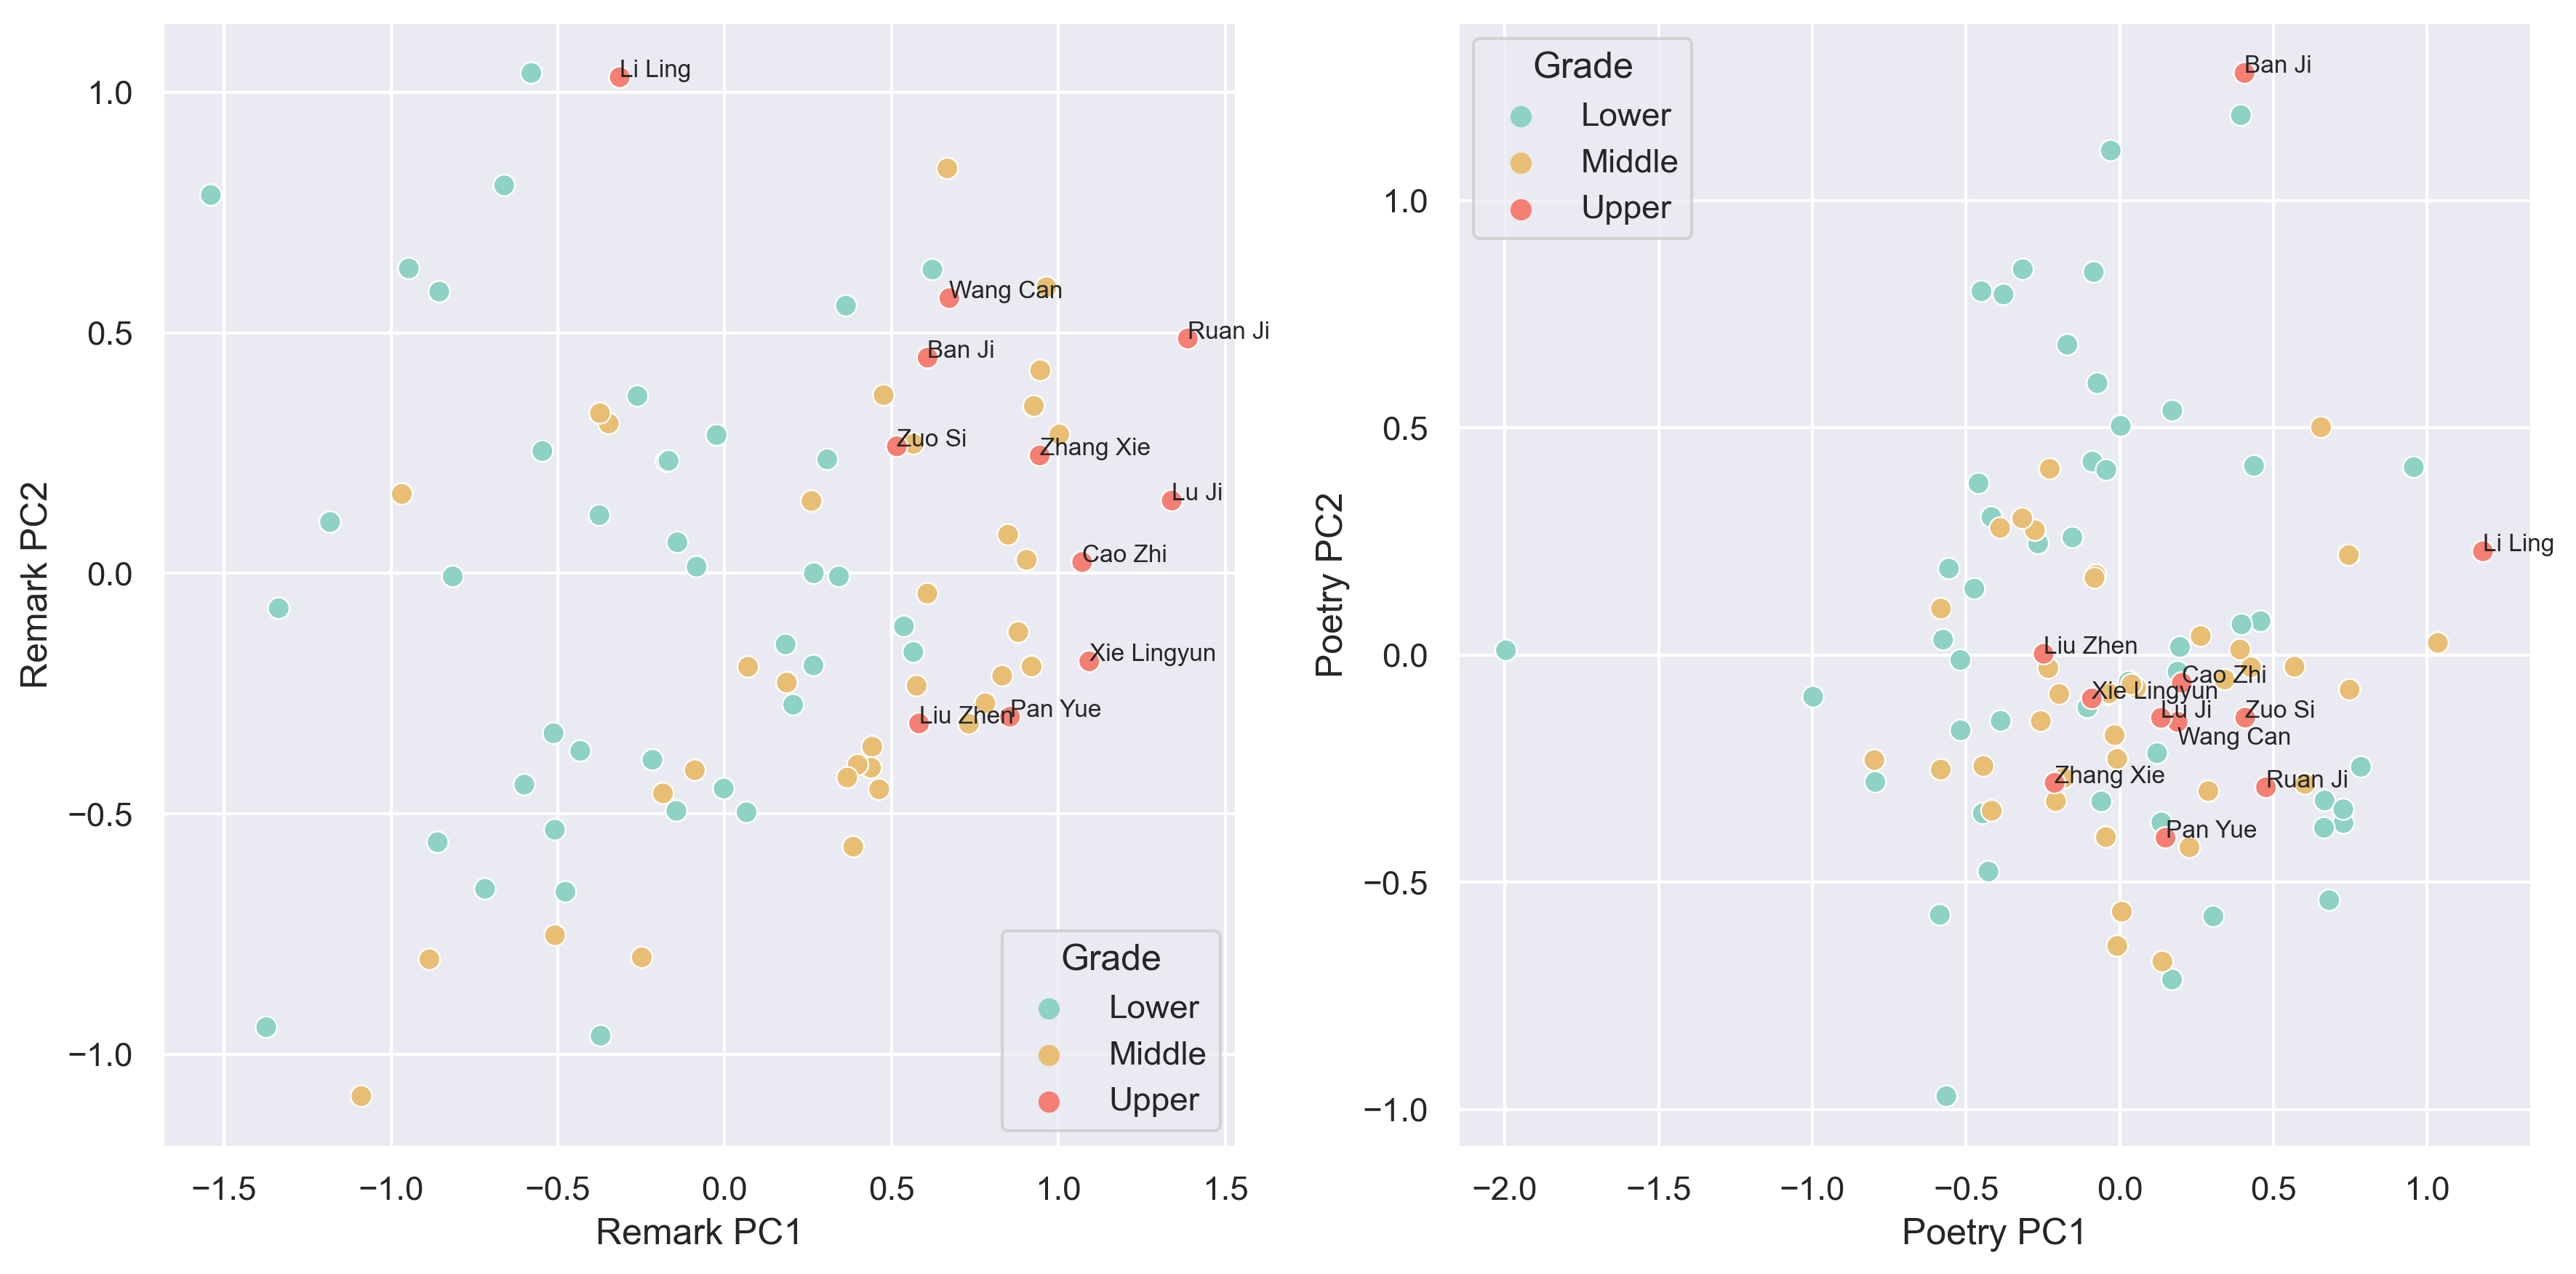

In [21]:
# Visualize PCA of remark and poetry embeddings and color the scatterplot based on grades
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
mpl.rcParams['figure.dpi'] = 300

def plot_embedding(X, Y, ranks, labels, title, ax, palette, legend, flag):
    sc = sns.scatterplot(x=X, y=Y, hue=ranks, palette=palette, s=50, ax=ax)
    for x, y, rank, lbl in zip(X, Y, ranks, labels):
        if flag == 1:
            if lbl == 'Wang Can': # Manually adjust 王粲's label
                ax.text(x, y-0.05, lbl, fontsize=8)
            elif rank == 'Upper': # Only label upper-grade poets
                ax.text(x, y, lbl, fontsize=8)
        elif rank == 'Upper':
            ax.text(x, y, lbl, fontsize=8)
    ax.legend(loc=legend, title='Grade')
    return sc

pca_df = pca_df.sort_values('Rank')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sc1 = plot_embedding(
    pca_df['Remark PC1'],
    pca_df['Remark PC2'],    
    pca_df['Rank'],
    pca_df['Author Pinyin'],
    title="Criticism Embeddings",
    ax=ax1,
    palette=['#8DD2C5', '#E8BE74', '#F47F72'],
    legend='lower right',
    flag=0
)
sc2 = plot_embedding(
    pca_df['Poetry PC1'],
    pca_df['Poetry PC2'],    
    pca_df['Rank'],
    pca_df['Author Pinyin'],
    title="Poem Embeddings",
    ax=ax2,
    palette=['#8DD2C5', '#E8BE74', '#F47F72'],
    legend='upper left',
    flag=1
)
plt.tight_layout()
plt.show()

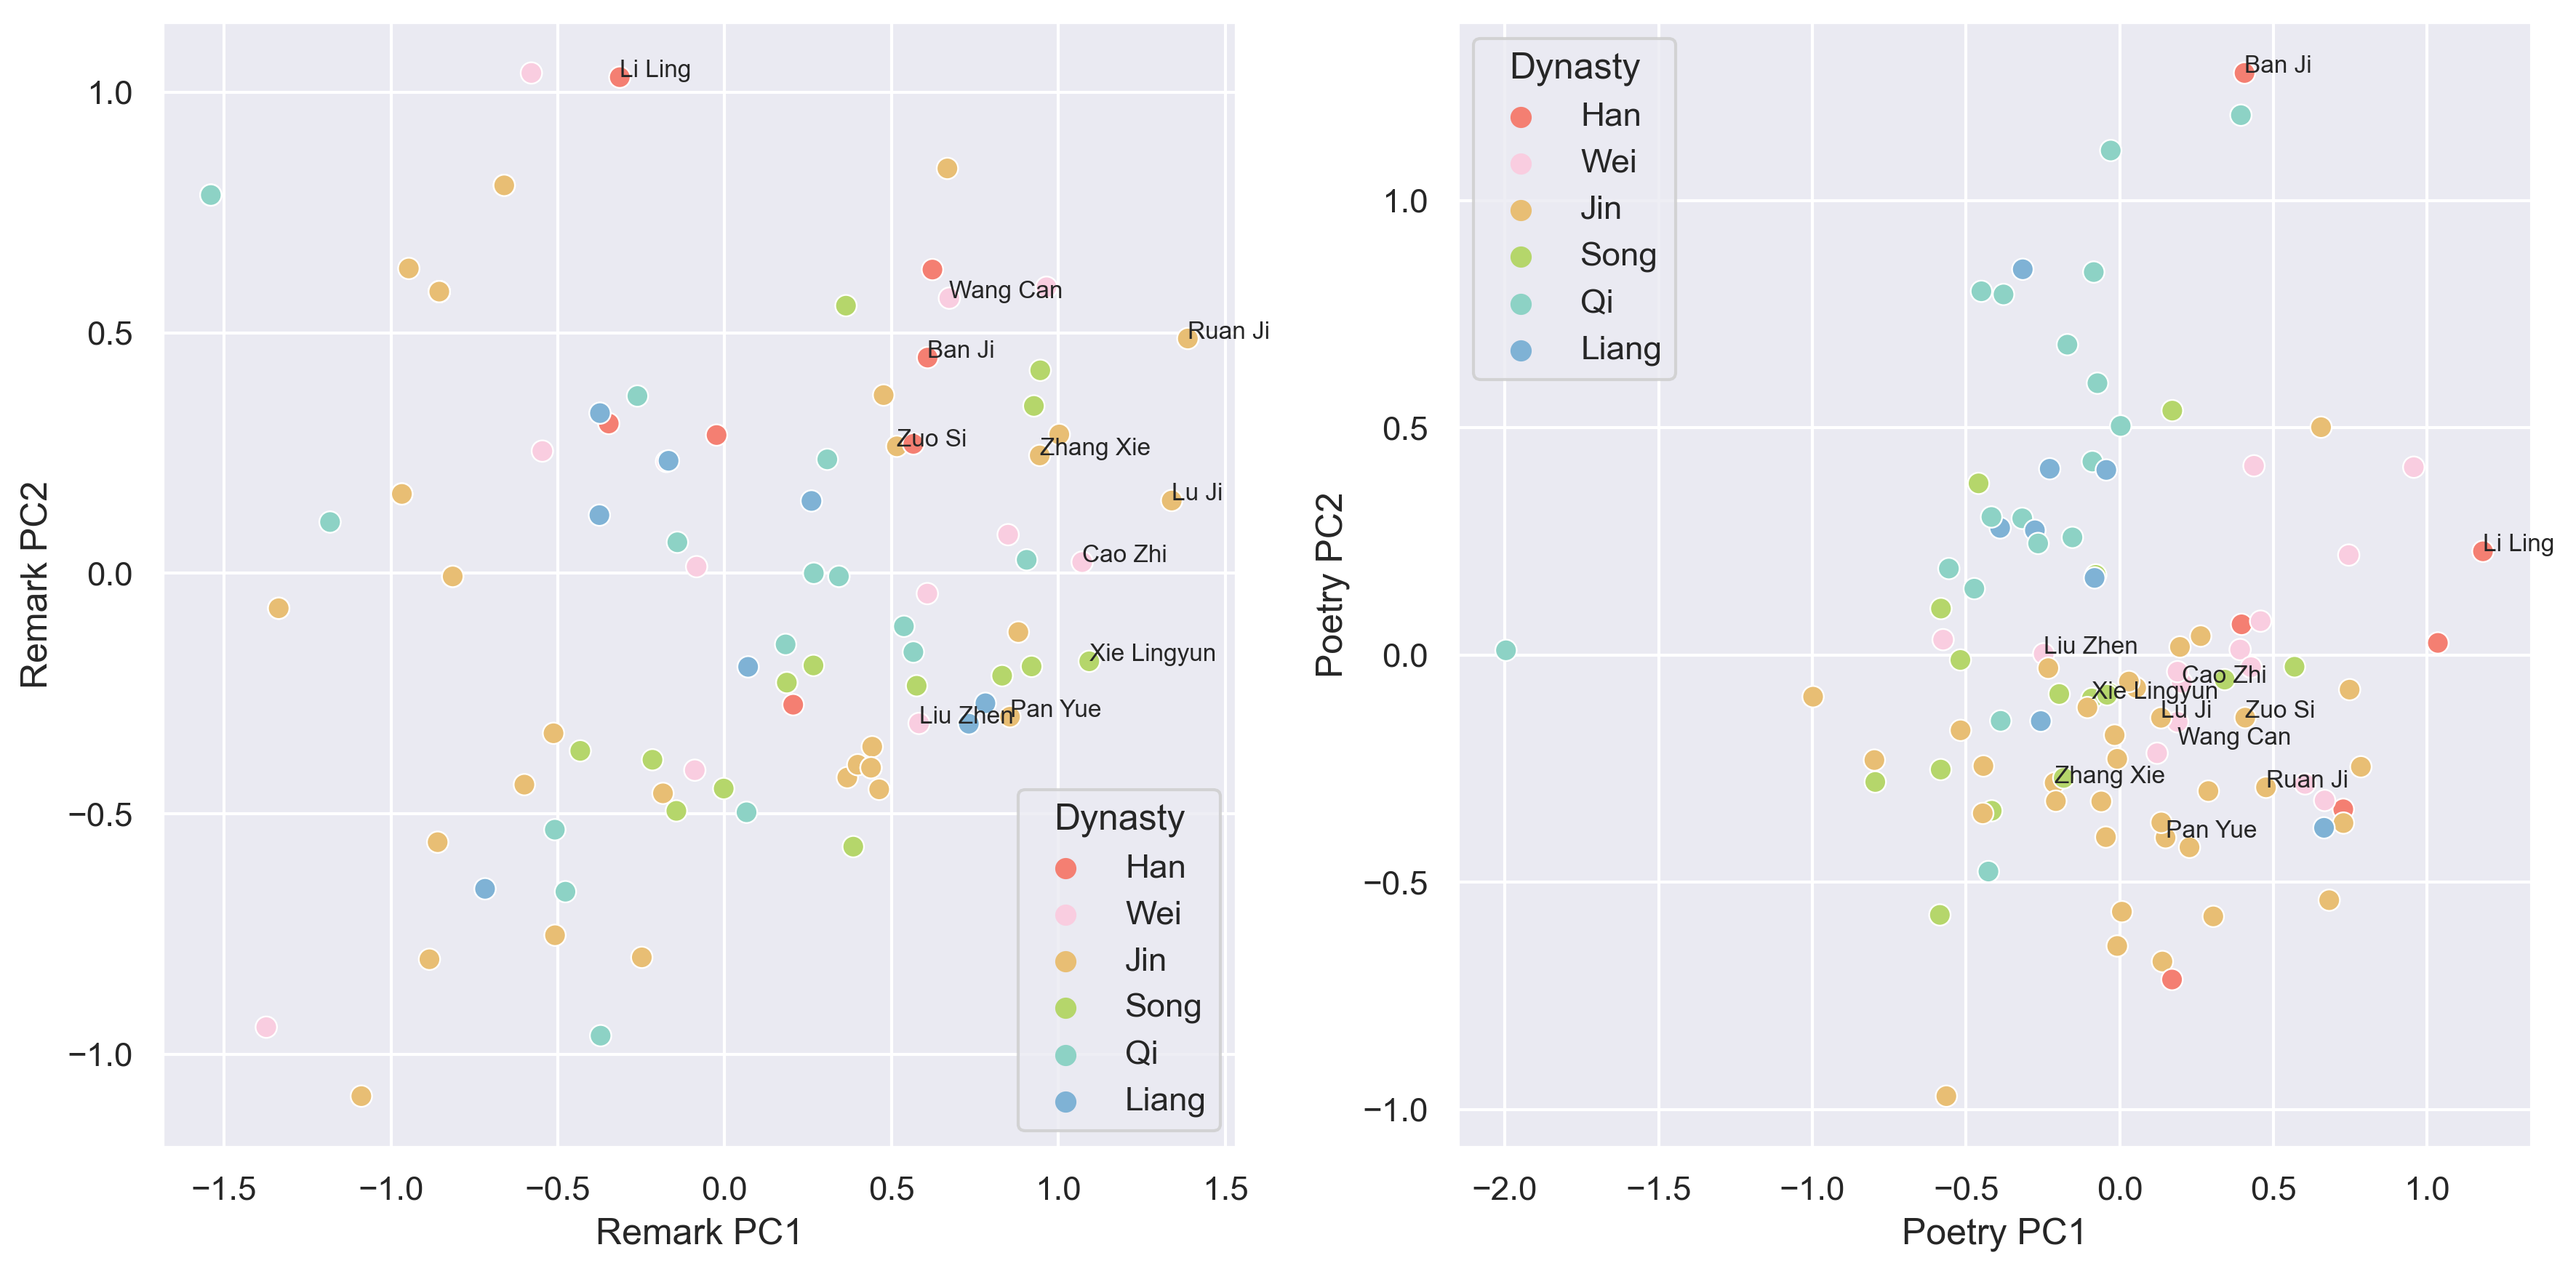

In [22]:
# Visualize PCA of remark and poetry embeddings and color the scatterplot based on dynastic periods
def plot_embedding(X, Y, ranks, dynasties, labels, title, ax, palette, legend, flag):
    sc = sns.scatterplot(x=X, y=Y, hue=dynasties, palette=palette, s=50, ax=ax)
    for x, y, rank, lbl in zip(X, Y, ranks, labels):
        if flag == 1:
            if lbl == 'Wang Can': # Manually adjust 王粲's label
                ax.text(x, y-0.05, lbl, fontsize=8)
            elif rank == 'Upper': # Only label upper-grade poets
                ax.text(x, y, lbl, fontsize=8)
        elif rank == 'Upper':
            ax.text(x, y, lbl, fontsize=8)
    ax.legend(loc=legend, title='Dynasty')
    return sc

pca_df = pca_df.sort_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
sc1 = plot_embedding(
    pca_df['Remark PC1'],
    pca_df['Remark PC2'],
    pca_df['Rank'],
    pca_df['Dynasty'],
    pca_df['Author Pinyin'],
    title="Criticism Embeddings",
    ax=ax1,
    palette=['#F47F72', '#F9CDE0', '#E8BE74', '#B5D66B', '#8DD2C5', '#7FB2D5'],
    legend='lower right',
    flag=0
)
sc2 = plot_embedding(
    pca_df['Poetry PC1'],
    pca_df['Poetry PC2'],
    pca_df['Rank'],
    pca_df['Dynasty'],
    pca_df['Author Pinyin'],
    title="Poem Embeddings",
    ax=ax2,
    palette=['#F47F72', '#F9CDE0', '#E8BE74', '#B5D66B', '#8DD2C5', '#7FB2D5'],
    legend='upper left',
    flag=1
)
plt.tight_layout()
plt.show()

# Classification

In [23]:
# Use leave-one-out cross-validation to classify poets into different grades using logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut

authors = shipin_both_embeddings['Author Pinyin'].tolist()
y = shipin_both_embeddings['Rank'].values
X_emb = np.stack(shipin_both_embeddings['Embedding'].values)
X_poem = np.stack(shipin_both_embeddings['Poem_Embedding'].values)

loo = LeaveOneOut()
pred_emb  = np.zeros_like(y)
pred_poem = np.zeros_like(y)

for train_idx, test_idx in loo.split(X_emb):
    clf1 = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf1.fit(X_emb[train_idx], y[train_idx])
    pred_emb[test_idx[0]] = clf1.predict(X_emb[test_idx])[0]

    clf2 = LogisticRegression(max_iter=1000, class_weight='balanced')
    clf2.fit(X_poem[train_idx], y[train_idx])
    pred_poem[test_idx[0]] = clf2.predict(X_poem[test_idx])[0]

classification_results = pd.DataFrame({
    'Author': authors,
    'True Rank': y,
    'Criticism Pred': pred_emb,
    'Poem Pred': pred_poem
})
classification_results

,Author,True Rank,Criticism Pred,Poem Pred
0,Li Ling,Upper,Middle,Lower
1,Ban Ji,Upper,Middle,Lower
2,Cao Zhi,Upper,Upper,Upper
3,Liu Zhen,Upper,Middle,Lower
4,Wang Can,Upper,Upper,Middle
...,...,...,...,...
92,Bian Bin,Lower,Lower,Lower
93,Fan Zhen,Lower,Lower,Upper
94,Lu Jue,Lower,Lower,Middle
95,Yu Xi,Lower,Lower,Lower


In [24]:
# Merge with poets' additional information and print all results
pd.set_option('display.max_rows', 100)
classification_results = classification_results.merge(shipin_both_embeddings[['Author Pinyin', 'Dynasty', 'Origin Group']],
                                                     left_on = 'Author', right_on = 'Author Pinyin')
classification_results

,Author,True Rank,Criticism Pred,Poem Pred,Author Pinyin,Dynasty,Origin Group
0,Li Ling,Upper,Middle,Lower,Li Ling,Han,Chuci
1,Ban Ji,Upper,Middle,Lower,Ban Ji,Han,Chuci
2,Cao Zhi,Upper,Upper,Upper,Cao Zhi,Wei,Shijing
3,Liu Zhen,Upper,Middle,Lower,Liu Zhen,Wei,Shijing
4,Wang Can,Upper,Upper,Middle,Wang Can,Wei,Chuci
5,Ruan Ji,Upper,Upper,Upper,Ruan Ji,Jin,Shijing
6,Lu Ji,Upper,Upper,Middle,Lu Ji,Jin,Shijing
7,Pan Yue,Upper,Upper,Middle,Pan Yue,Jin,Chuci
8,Zhang Xie,Upper,Upper,Middle,Zhang Xie,Jin,Chuci
9,Zuo Si,Upper,Upper,Middle,Zuo Si,Jin,Shijing


In [25]:
# Print overall accuracies of remark/poetry classifiers and accuracies based on dynasty/origin group
total = len(classification_results)
crit_correct = (classification_results['Criticism Pred'] == classification_results['True Rank']).sum()
poem_correct = (classification_results['Poem Pred'] == classification_results['True Rank']).sum()
print(f"Overall remark accuracy: {crit_correct/total*100:.2f}% ({crit_correct}/{total})")
print(f"Overall poetry accuracy: {poem_correct/total*100:.2f}% ({poem_correct}/{total})\n")

print("By Dynasty:")
for dynasty, grp in classification_results.groupby('Dynasty'):
    n = len(grp)
    c_corr = (grp['Criticism Pred'] == grp['True Rank']).sum()
    p_corr = (grp['Poem Pred'] == grp['True Rank']).sum()
    print(f"  {dynasty:10s} | Remark: {c_corr/n*100:.2f}% ({c_corr}/{n})  "
          f"Poetry: {p_corr/n*100:.2f}% ({p_corr}/{n})")
print()

print("By Origin Group:")
for origin, grp in classification_results.groupby('Origin Group'):
    n = len(grp)
    c_corr = (grp['Criticism Pred'] == grp['True Rank']).sum()
    p_corr = (grp['Poem Pred'] == grp['True Rank']).sum()
    print(f"  {origin:10s} | Remark: {c_corr/n*100:.2f}% ({c_corr}/{n})  "
          f"Poetry: {p_corr/n*100:.2f}% ({p_corr}/{n})")

Overall remark accuracy: 75.26% (73/97)
Overall poetry accuracy: 39.18% (38/97)

By Dynasty:
  Han        | Remark: 28.57% (2/7)  Poetry: 0.00% (0/7)
  Jin        | Remark: 82.35% (28/34)  Poetry: 35.29% (12/34)
  Liang      | Remark: 75.00% (6/8)  Poetry: 37.50% (3/8)
  Qi         | Remark: 83.33% (15/18)  Poetry: 72.22% (13/18)
  Song       | Remark: 62.50% (10/16)  Poetry: 50.00% (8/16)
  Wei        | Remark: 85.71% (12/14)  Poetry: 14.29% (2/14)

By Origin Group:
  Chuci      | Remark: 61.90% (13/21)  Poetry: 23.81% (5/21)
  Dual       | Remark: 50.00% (1/2)  Poetry: 50.00% (1/2)
  Shijing    | Remark: 88.89% (8/9)  Poetry: 55.56% (5/9)
  nan        | Remark: 79.37% (50/63)  Poetry: 39.68% (25/63)


In [26]:
# Classification details: remark-based classifier, by dynasty
labels = ['Upper→Upper', 'Upper→Middle', 'Upper→Lower', 'Middle→Upper','Middle→Middle','Middle→Lower',
          'Lower→Upper', 'Lower→Middle', 'Lower→Lower']
dynasty_order = ['Han', 'Wei', 'Jin', 'Song', 'Qi', 'Liang']
crit_dyn = (classification_results.groupby(['Dynasty','True Rank','Criticism Pred']).size().rename('Count').reset_index())
crit_dyn['Prop'] = crit_dyn.groupby(['Dynasty','True Rank'])['Count'].transform(lambda x: x / x.sum())
crit_dyn['Label'] = crit_dyn['True Rank'] + '→' + crit_dyn['Criticism Pred']
crit_dyn_pivot = (crit_dyn.pivot_table(index='Dynasty', columns='Label', values='Prop', fill_value=0)
                 .reindex(columns=labels, fill_value=0).reindex(dynasty_order))
crit_dyn_pivot

Label,Upper→Upper,Upper→Middle,Upper→Lower,Middle→Upper,Middle→Middle,Middle→Lower,Lower→Upper,Lower→Middle,Lower→Lower
Dynasty,,,,,,,,,
Han,0.000000,1.000000,0,0.000000,0.500000,0.5000,0,0.666667,0.333333
Wei,0.666667,0.333333,0,0.250000,0.750000,0.0000,0,0.000000,1.000000
Jin,1.000000,0.000000,0,0.125000,0.687500,0.1875,0,0.076923,0.923077
Song,1.000000,0.000000,0,0.333333,0.666667,0.0000,0,0.500000,0.500000
Qi,0.000000,0.000000,0,0.000000,1.000000,0.0000,0,0.176471,0.823529
Liang,0.000000,0.000000,0,0.000000,0.800000,0.2000,0,0.333333,0.666667


In [27]:
# Classification details: remark-based classifier, by origin
origin_order = ['Chuci', 'Shijing', 'Dual', 'No Origin']
crit_orig = (classification_results.groupby(['Origin Group','True Rank','Criticism Pred']).size().rename('Count').reset_index())
crit_orig['Prop'] = crit_orig.groupby(['Origin Group','True Rank'])['Count'].transform(lambda x: x / x.sum())
crit_orig['Label'] = crit_orig['True Rank'] + '→' + crit_orig['Criticism Pred']
crit_orig_pivot = (crit_orig.pivot_table(index='Origin Group', columns='Label', values='Prop', fill_value=0)
                 .reindex(columns=labels, fill_value=0))
crit_orig_pivot.index = ['No Origin' if idx == 'nan' else idx for idx in crit_orig_pivot.index]
crit_orig_pivot = crit_orig_pivot.reindex(origin_order)
crit_orig_pivot

Label,Upper→Upper,Upper→Middle,Upper→Lower,Middle→Upper,Middle→Middle,Middle→Lower,Lower→Upper,Lower→Middle,Lower→Lower
Chuci,0.6,0.4,0,0.250000,0.625000,0.125000,0,0.000000,0.000000
Shijing,0.8,0.2,0,0.000000,1.000000,0.000000,0,0.000000,1.000000
Dual,1.0,0.0,0,1.000000,0.000000,0.000000,0,0.000000,0.000000
No Origin,0.0,0.0,0,0.052632,0.789474,0.157895,0,0.204545,0.795455


In [28]:
# Classification details: poetry-based classifier, by dynasty
labels = ['Upper→Upper', 'Upper→Middle', 'Upper→Lower', 'Middle→Upper','Middle→Middle','Middle→Lower',
          'Lower→Upper', 'Lower→Middle', 'Lower→Lower']

poem_dyn = (classification_results.groupby(['Dynasty','True Rank','Poem Pred']).size().rename('Count').reset_index())
poem_dyn['Prop'] = poem_dyn.groupby(['Dynasty','True Rank'])['Count'].transform(lambda x: x / x.sum())
poem_dyn['Label'] = poem_dyn['True Rank'] + '→' + poem_dyn['Poem Pred']
poem_dyn_pivot = (poem_dyn.pivot_table(index='Dynasty', columns='Label', values='Prop', fill_value=0)
                 .reindex(columns=labels, fill_value=0).reindex(dynasty_order))
poem_dyn_pivot

Label,Upper→Upper,Upper→Middle,Upper→Lower,Middle→Upper,Middle→Middle,Middle→Lower,Lower→Upper,Lower→Middle,Lower→Lower
Dynasty,,,,,,,,,
Han,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333,0.666667,0.000000
Wei,0.333333,0.333333,0.333333,1.000000,0.000000,0.000000,0.714286,0.142857,0.142857
Jin,0.200000,0.800000,0.000000,0.250000,0.625000,0.125000,0.307692,0.615385,0.076923
Song,0.000000,1.000000,0.000000,0.111111,0.555556,0.333333,0.000000,0.500000,0.500000
Qi,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.235294,0.764706
Liang,0.000000,0.000000,0.000000,0.000000,0.200000,0.800000,0.333333,0.000000,0.666667


In [29]:
# Classification details: poetry-based classifier, by origin
poem_orig = (classification_results.groupby(['Origin Group','True Rank','Poem Pred']).size().rename('Count').reset_index())
poem_orig['Prop'] = poem_orig.groupby(['Origin Group','True Rank'])['Count'].transform(lambda x: x / x.sum())
poem_orig['Label'] = poem_orig['True Rank'] + '→' + poem_orig['Poem Pred']
poem_orig_pivot = (poem_orig.pivot_table(index='Origin Group', columns='Label', values='Prop', fill_value=0)
                 .reindex(columns=labels, fill_value=0))
poem_orig_pivot.index = ['No Origin' if idx == 'nan' else idx for idx in poem_orig_pivot.index]
poem_orig_pivot = poem_orig_pivot.reindex(origin_order)
poem_orig_pivot

Label,Upper→Upper,Upper→Middle,Upper→Lower,Middle→Upper,Middle→Middle,Middle→Lower,Lower→Upper,Lower→Middle,Lower→Lower
Chuci,0.0,0.6,0.4,0.312500,0.312500,0.375000,0.00,0.000000,0.000000
Shijing,0.4,0.4,0.2,0.000000,1.000000,0.000000,0.00,0.333333,0.666667
Dual,0.0,1.0,0.0,0.000000,1.000000,0.000000,0.00,0.000000,0.000000
No Origin,0.0,0.0,0.0,0.210526,0.473684,0.315789,0.25,0.386364,0.363636


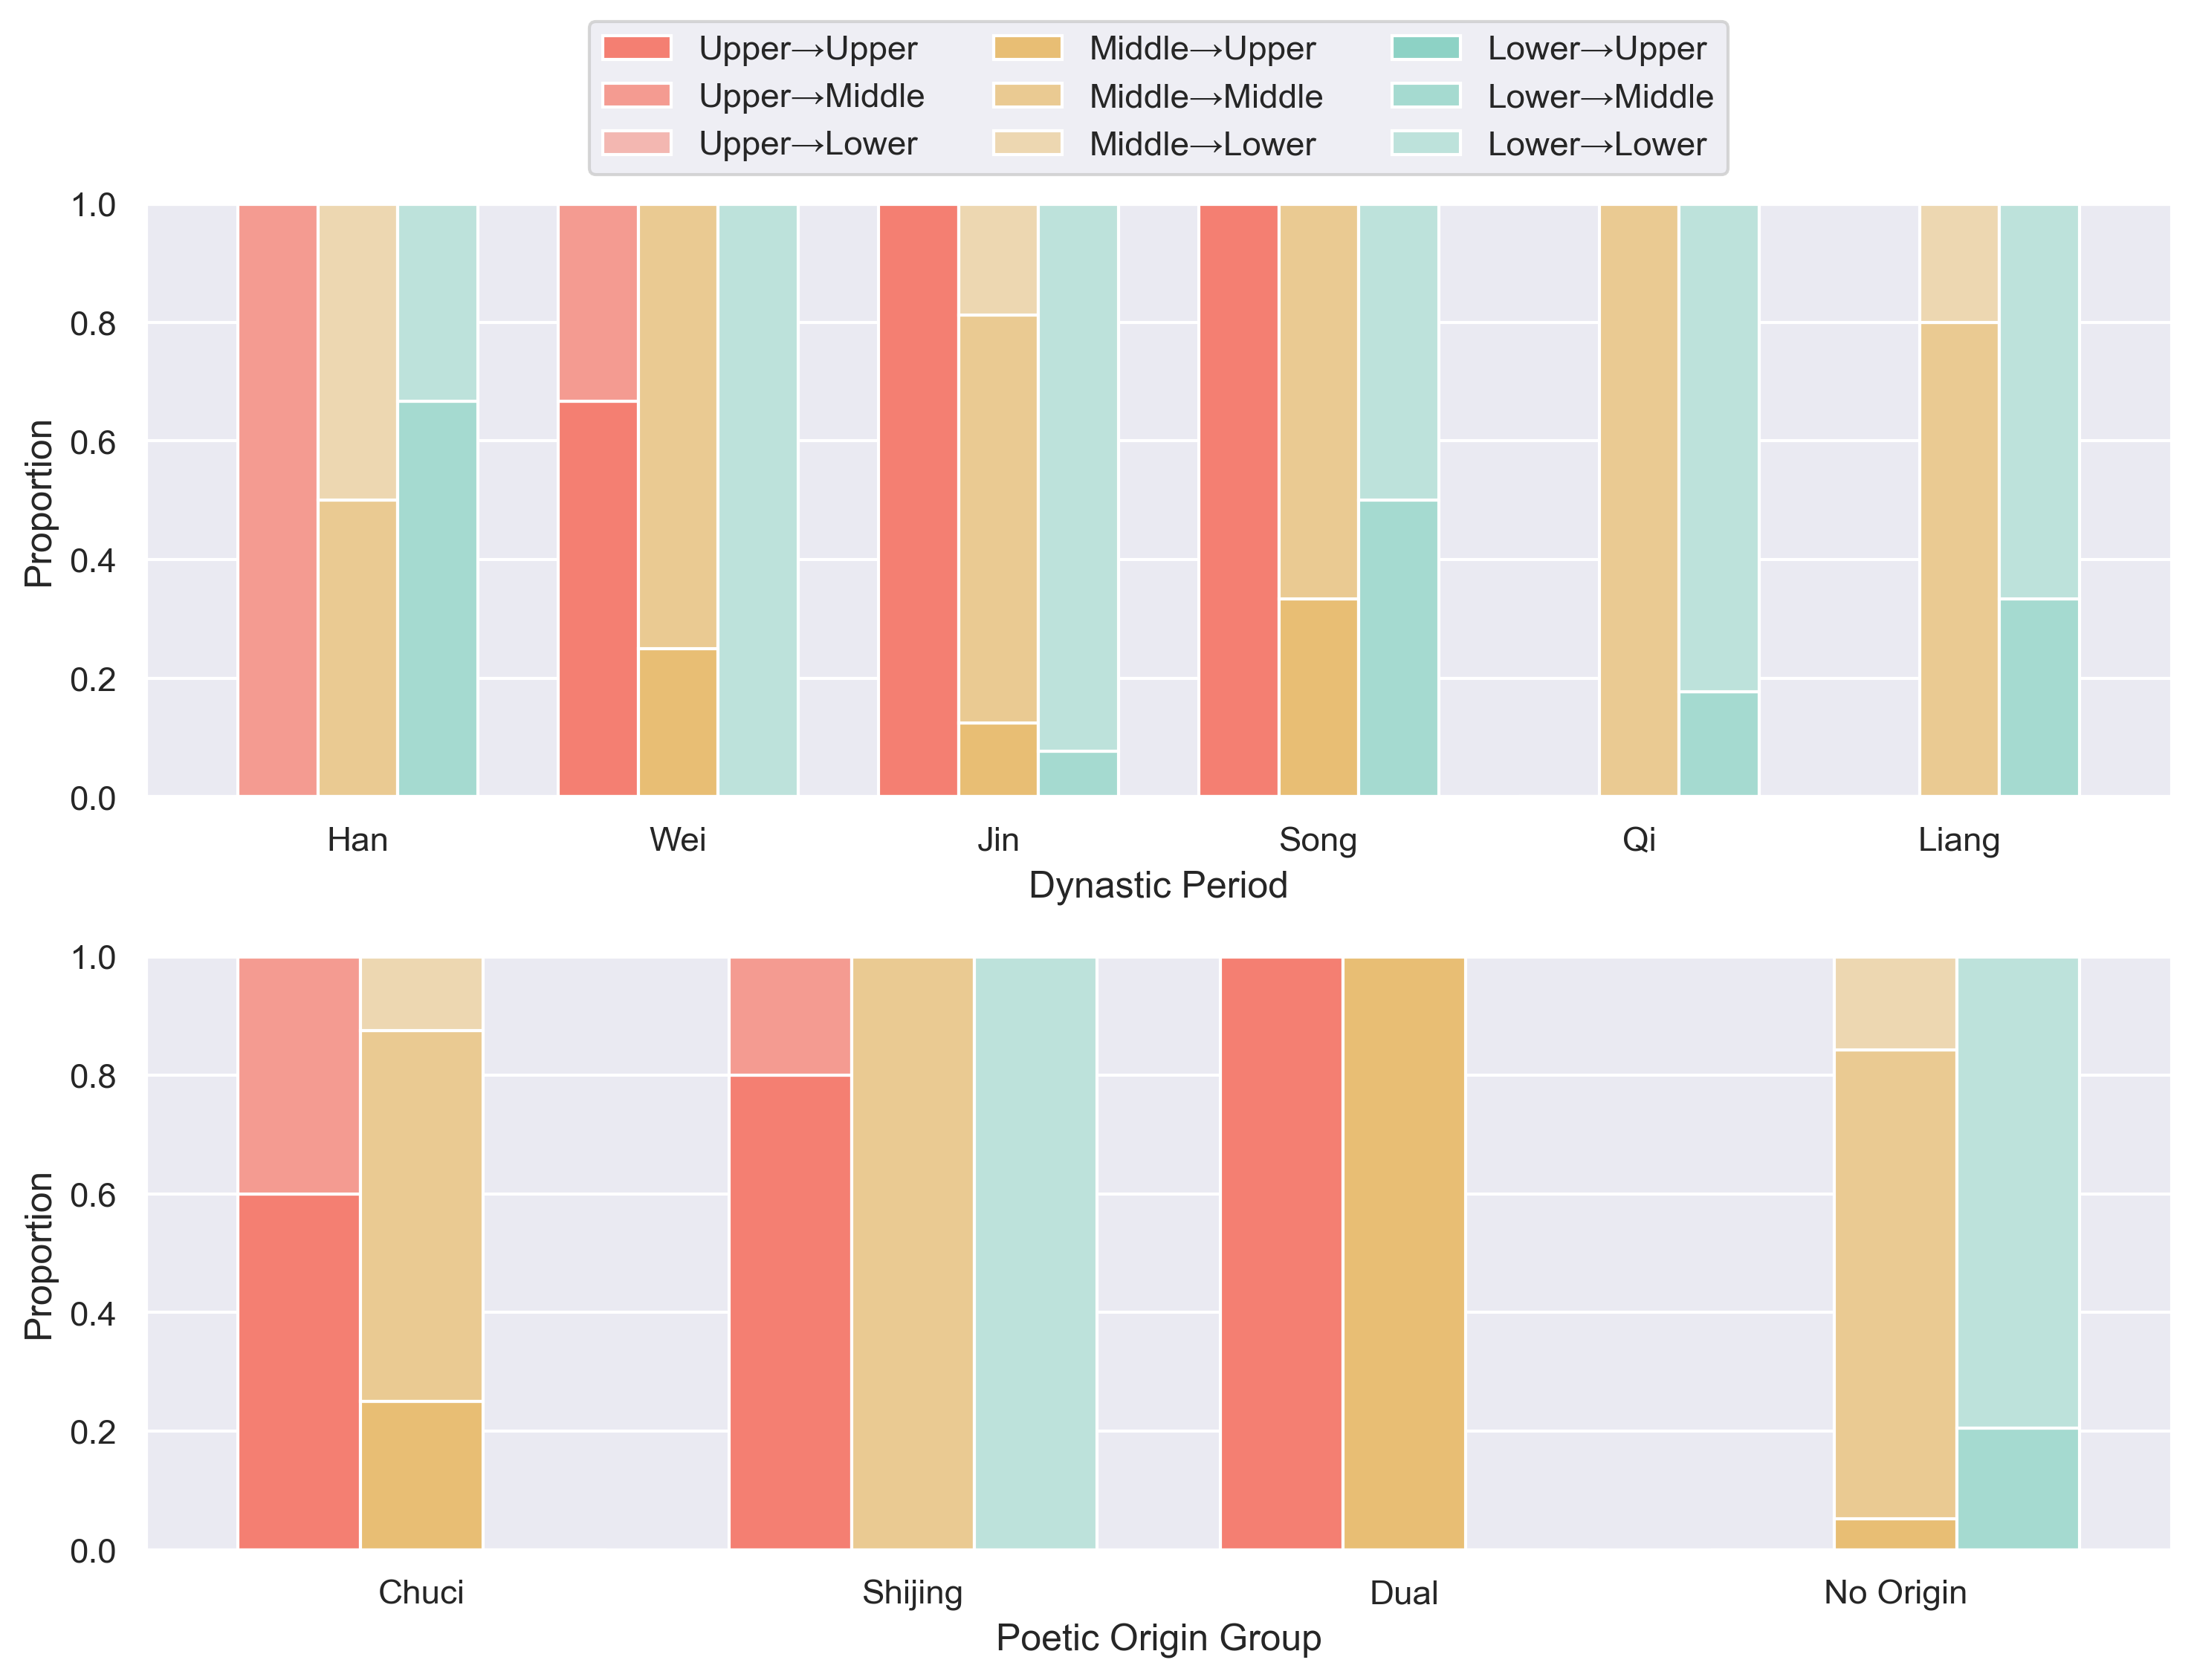

In [30]:
# Visualize the classification details of the remark-based classifier in stacked bar charts
base_colors = ['#F47F72', '#E8BE74', '#8DD2C5']
levels = ['Upper', 'Middle', 'Lower']
palette = {t: sns.light_palette(base, n_colors=5) for t, base in zip(levels, base_colors)}

def plot_stacked(pivot, ax, x_label, legend):
    bar_width = 0.25
    x = np.arange(len(pivot))
    seen = set()

    for i, t in enumerate(levels):
        bottom = np.zeros(len(pivot))
        for j, p in enumerate(levels):
            col = f"{t}→{p}"
            vals = pivot[col].values
            color = palette[t][4-j]
            label = col if col not in seen else None
            seen.add(col)
            ax.bar(x + (i-1)*bar_width, vals, width=bar_width, bottom=bottom, label=label, color=color)
            bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, ha='center')
    ax.set_xlabel(x_label)
    ax.set_ylabel("Proportion")
    if legend == True:
        ax.legend(ncol=3, bbox_to_anchor=(0,1.02,1,0.2), loc="lower center")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.7), sharex=False)
plot_stacked(crit_dyn_pivot, ax1, 'Dynastic Period', legend=True)
plot_stacked(crit_orig_pivot, ax2, 'Poetic Origin Group', legend=False)
plt.tight_layout()
plt.show()

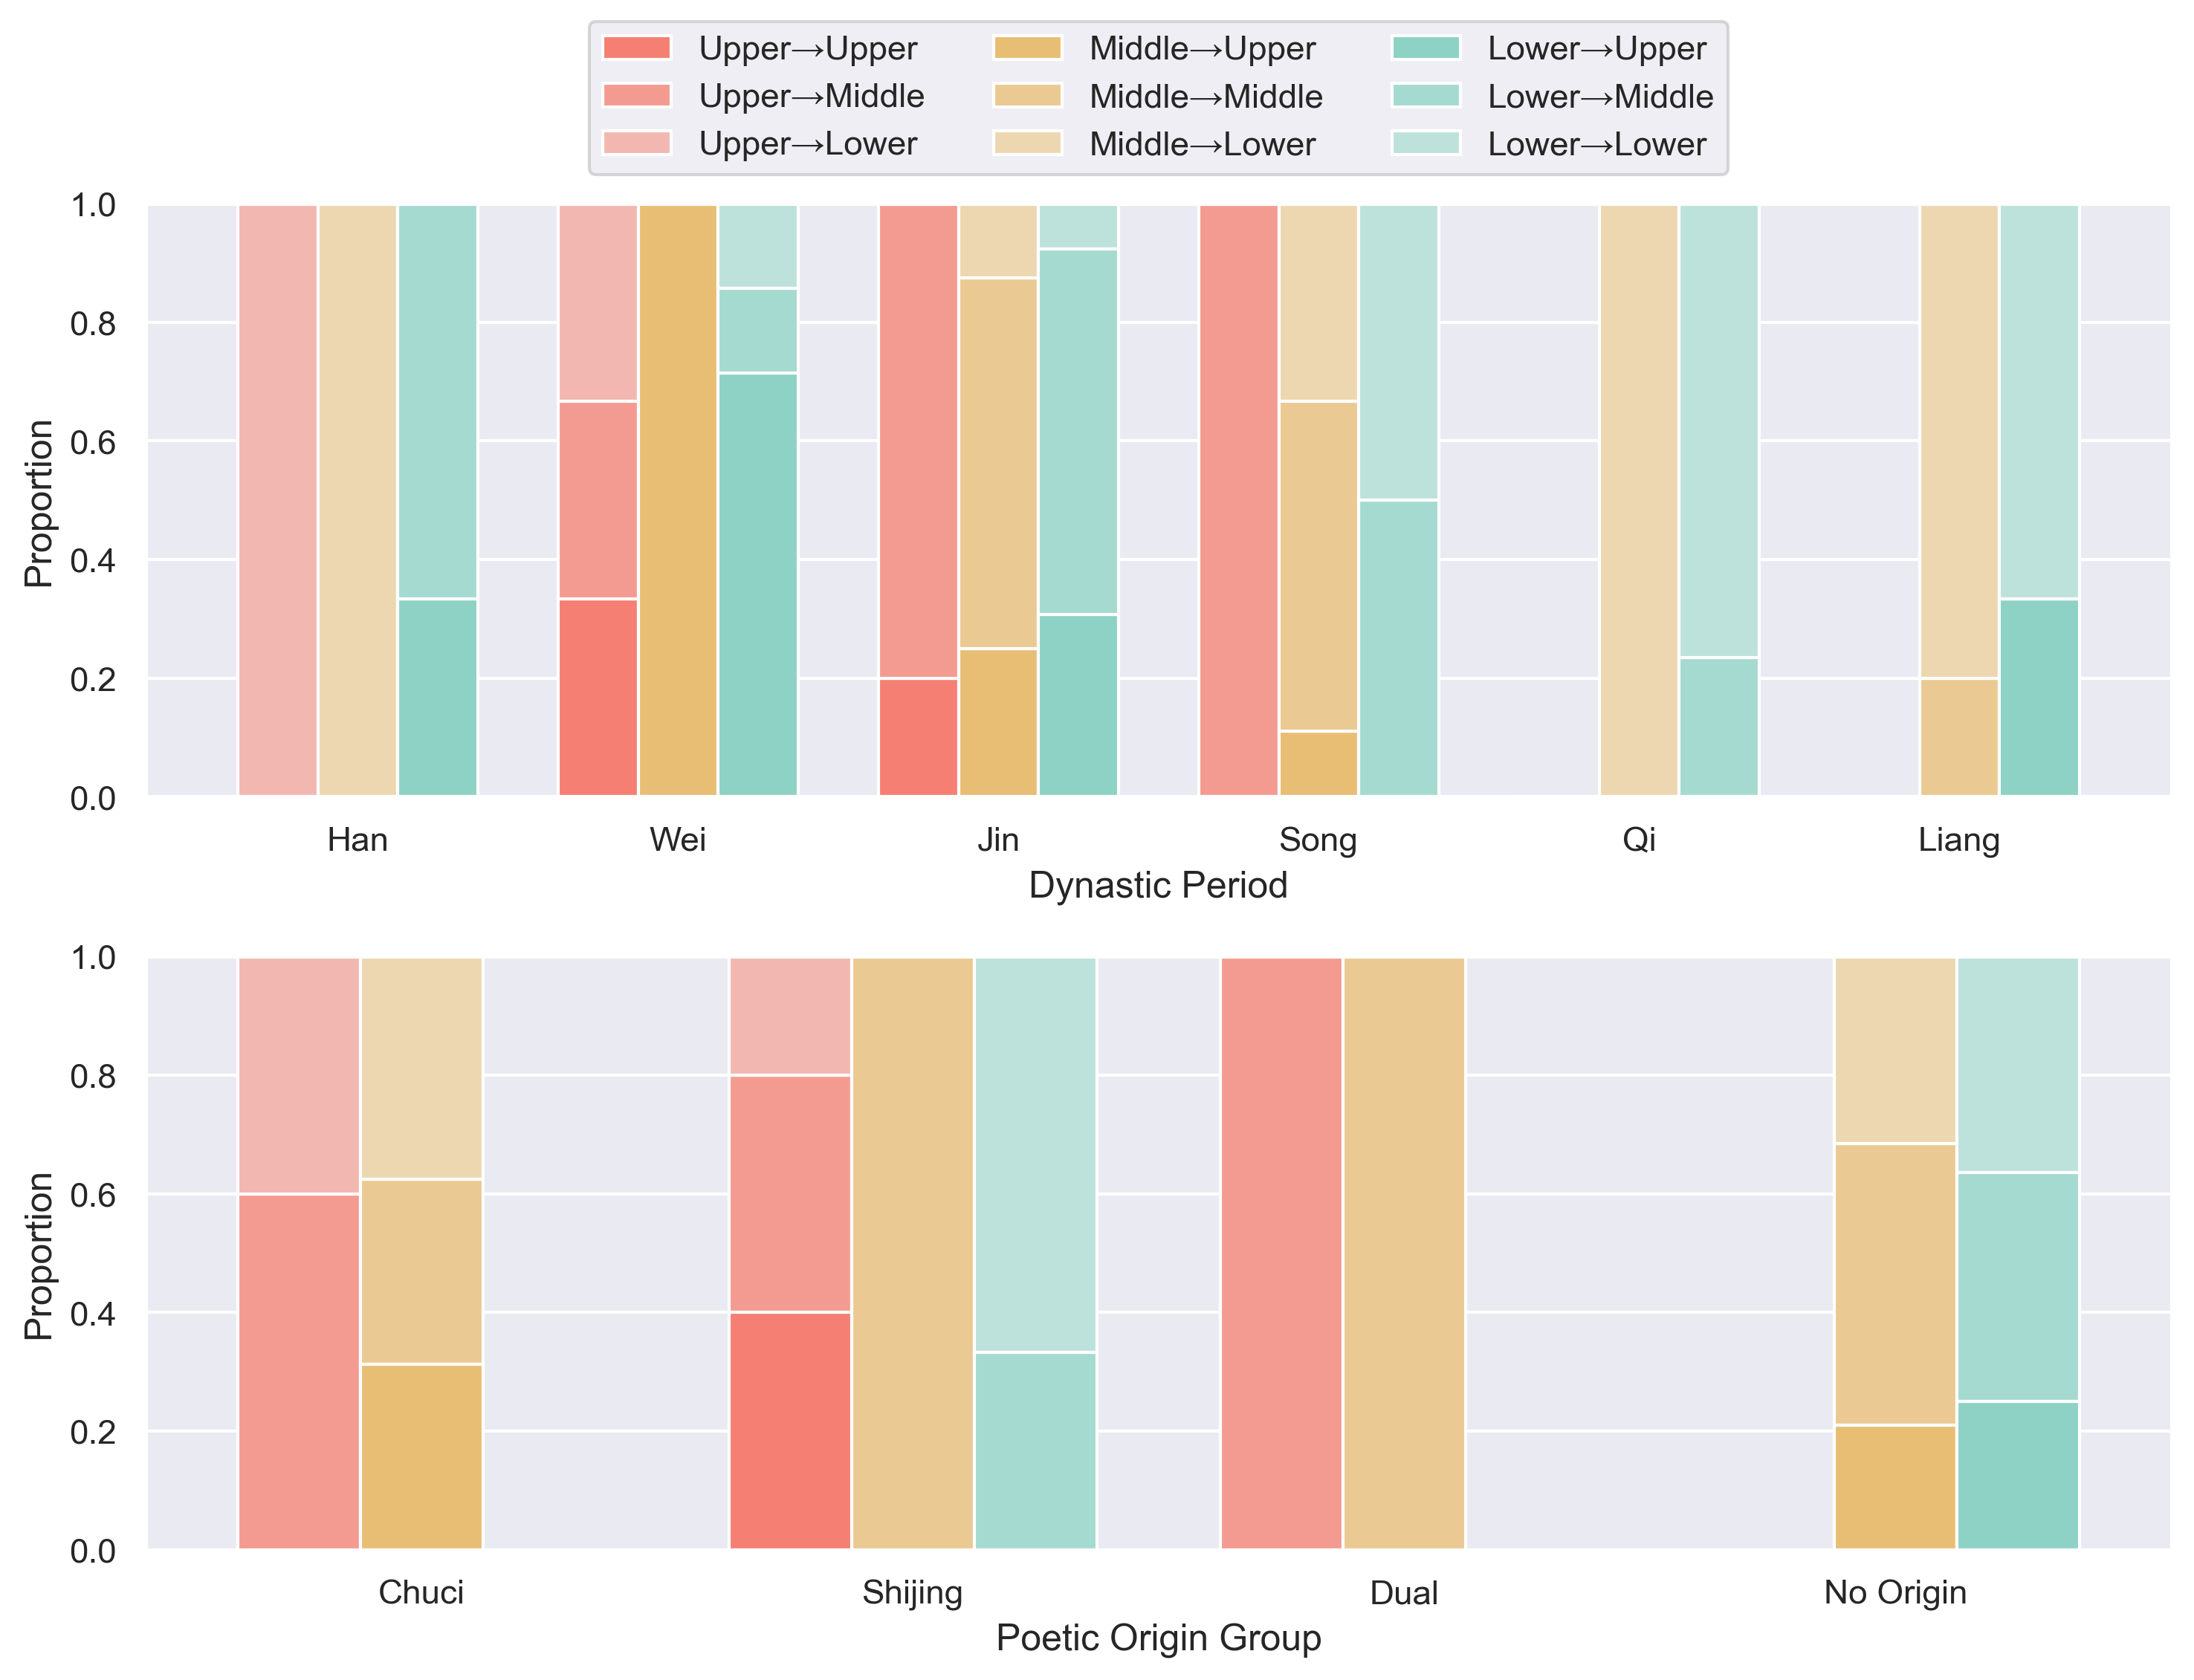

In [31]:
# Visualize the classification details of the poetry-based classifier in stacked bar charts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7.7), sharex=False)
plot_stacked(poem_dyn_pivot, ax1, 'Dynastic Period', legend=True)
plot_stacked(poem_orig_pivot, ax2, 'Poetic Origin Group', legend=False)
plt.tight_layout()
plt.show()